Fetching data for CIK: 0000320193...
Successfully fetched:  (Revenues)
Successfully fetched:  (Net Income)
Successfully fetched:  (Liabilities)
Successfully fetched:  (Equity)
Successfully fetched:  (Cash Flow)

Plotting financial data in separate subplots...


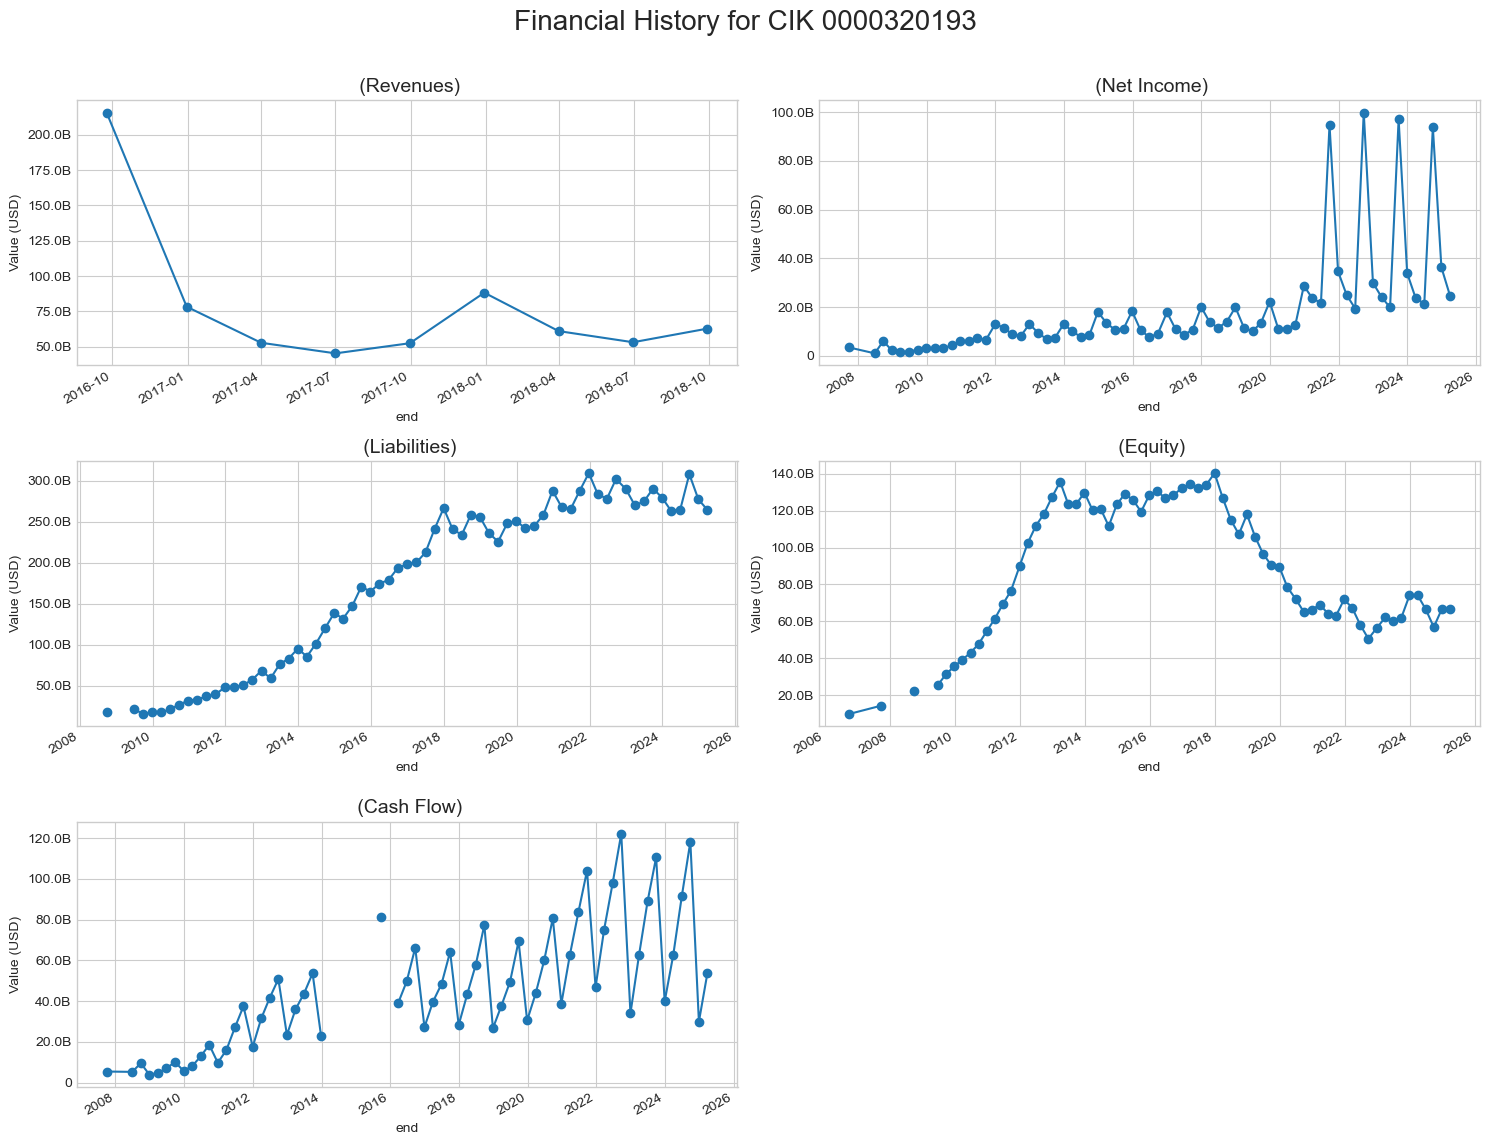

In [19]:
# -*- coding: utf-8 -*-
"""
SEC Filing Scraper - Multi-Subplot Plotter
"""

# import modules
import requests
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. تنظیمات اولیه ---
# create request header
headers = {'User-Agent': "yourname@yourdomain.com"}

# CIK شرکت مورد نظر را انتخاب کنید (مثال: اپل)
cik = '0000320193' 

# لیستی از شاخص‌هایی که می‌خواهیم رسم کنیم
concepts_to_plot = {
    'Revenues': ' (Revenues)',
    'NetIncomeLoss': ' (Net Income)',
    'Liabilities': ' (Liabilities)',
    'StockholdersEquity': ' (Equity)',
    'NetCashProvidedByUsedInOperatingActivities': ' (Cash Flow)'
}

print(f"Fetching data for CIK: {cik}...")

# --- 2. دریافت و پردازش داده‌ها برای تمام شاخص‌ها ---
all_data_frames = []

for concept_tag, concept_name in concepts_to_plot.items():
    url = f'https://data.sec.gov/api/xbrl/companyconcept/CIK{cik}/us-gaap/{concept_tag}.json'
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200 and 'units' in response.json() and 'USD' in response.json()['units']:
        print(f"Successfully fetched: {concept_name}")
        df = pd.DataFrame.from_dict(response.json()['units']['USD'])
        df = df[['end', 'val', 'form']]
        df = df[df['form'].isin(['10-Q', '10-K'])].copy()
        df['end'] = pd.to_datetime(df['end'])
        df['val'] = pd.to_numeric(df['val'])
        df = df.drop_duplicates(subset='end', keep='last')
        df = df.rename(columns={'val': concept_name}).set_index('end')[concept_name]
        all_data_frames.append(df)
    else:
        print(f"--> Could not fetch data for: {concept_name}")

# --- 3. ترکیب تمام دیتافریم‌ها در یک دیتافریم واحد ---
if all_data_frames:
    combined_df = pd.concat(all_data_frames, axis=1)
    combined_df = combined_df.sort_index()

    # --- 4. رسم هر شاخص در یک نمودار مجزا (Subplot) ---
    print("\nPlotting financial data in separate subplots...")
    
    # ایجاد یک شبکه 3x2 برای نمایش 5 نمودار
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
    # تبدیل آرایه دو بعدی محورها به یک لیست یک بعدی برای دسترسی آسان‌تر
    axes = axes.flatten() 
    
    # حلقه برای رسم هر ستون از دیتافریم در یک محور جداگانه
    for i, column in enumerate(combined_df.columns):
        ax = axes[i]
        combined_df[column].plot(ax=ax, marker='o', linestyle='-')
        ax.set_title(column, fontsize=14)
        ax.set_ylabel('Value (USD)')
        ax.grid(True)
        # فرمت‌دهی محور عمودی برای خوانایی بهتر
        ax.yaxis.set_major_formatter(lambda x, pos: f'{x/1e9:.1f}B' if x != 0 else '0')

    # حذف محور خالی آخر (چون 5 نمودار در یک شبکه 6 تایی داریم)
    for i in range(len(combined_df.columns), len(axes)):
        fig.delaxes(axes[i])
        
    fig.suptitle(f'Financial History for CIK {cik}', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # تنظیم فاصله برای جلوگیری از تداخل
    plt.show()
else:
    print("\nNo data to plot.")